# MNIST Digit Recognizer (with Keras)

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Load dataset

In [4]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Total images in training set: %d"%len(X_train))
print("Total images in test set: %d"%len(X_test))
print("Image dimension: %d X %d"%(X_train[0].shape[0],X_train[0].shape[1]))
print("Max pixel val: %d"%np.max(X_train))
print("Min pixel val: %d"%np.min(X_train))

Using TensorFlow backend.


Total images in training set: 60000
Total images in test set: 10000
Image dimension: 28 X 28
Max pixel val: 255
Min pixel val: 0


## Plot first 10 images

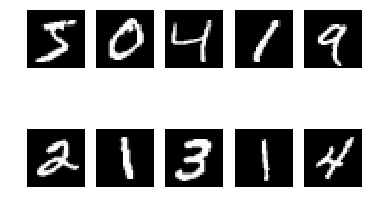

In [5]:
fig = plt.figure()
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    ax.axis('off')
    ax.imshow(X_train[i],cmap="gray")

### Image labels

In [6]:
print(y_train[:5])
print(y_train[5:10])

[5 0 4 1 9]
[2 1 3 1 4]


## Preprocess data

In [7]:
# All pixel values normalized between 0 and 1
normalize = lambda x: x/255.0
v_normalize = np.vectorize(normalize)

X_train_processed_norm = v_normalize(X_train)
X_test_processed_norm = v_normalize(X_test)

### One-hot encoding: Image labels

In [10]:
from keras.utils import np_utils

y_train_encoded = np_utils.to_categorical(y_train, 10)
y_test_encoded = np_utils.to_categorical(y_test, 10)

### First 10 encoded image labels

In [11]:
print(y_train_encoded[:10])

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


## Neural Network Architecture

In [12]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint

#### Use GridSearch to tune hyper-parameters

In [13]:
def nn_model(dropout_prob=0.0, num_layers=1):
    model = Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_prob))
    
    for i in range(1,num_layers):
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(dropout_prob))
    
    model.add(Dense(10, activation='softmax'))    
    
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [14]:
model = KerasClassifier(build_fn=nn_model, epochs=10, batch_size=100, verbose=0)

dropout_prob = [0.2,0.3,0.4]
num_layers = [2,3,4]

param_grid = dict(dropout_prob=dropout_prob, num_layers=num_layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train_processed_norm, y_train_encoded)

print("Best validation accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best validation accuracy: 0.977283 using {'dropout_prob': 0.2, 'num_layers': 2}


Tune batch-size using hyper-parameters obtained above

In [15]:
model = KerasClassifier(build_fn=nn_model, epochs=10, verbose=0)

dropout_prob = [0.2]
num_layers = [2]
batch_size = [50,100,150,10000,30000]

param_grid = dict(dropout_prob=dropout_prob, num_layers=num_layers, batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train_processed_norm, y_train_encoded)

print("Best validation accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best validation accuracy: 0.977717 using {'dropout_prob': 0.2, 'num_layers': 2, 'batch_size': 150}


Tune number of epochs using the tuned value of other hyper-parameters obtained above

In [16]:
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='mnist.model.best.hdf5',verbose=1, save_best_only=True)

results = model.fit(X_train_processed_norm, y_train_encoded, batch_size=150, epochs=30,
          validation_split=0.33, callbacks=[checkpointer],
          verbose=0, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_45 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_160 (Dense)            (None, 512)               401920    
_________________________________________________________________
dropout_116 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_161 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_117 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_162 (Dense)            (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Epoc

Test accuracy

In [17]:
model.load_weights('mnist.model.best.hdf5')
score = model.evaluate(X_test_processed_norm, y_test_encoded, verbose=0)
print('Test accuracy: %f' % score[1])

Test accuracy: 0.978600


## Convolutional Neural Network

In [21]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [22]:
X_train_processed_norm = X_train_processed_norm.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_processed_norm = X_test_processed_norm.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [25]:
def cnn_model(kernel_size=2, num_filters=1, num_dense_layers=1, dropout_prob=0.0):
    
    model = Sequential()
    model.add(Conv2D(filters=num_filters, kernel_size=kernel_size, strides=1, activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=num_filters, kernel_size=kernel_size, strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_prob))
        
    for i in range(1,num_dense_layers):
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(dropout_prob))
    
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

#### Use GridSearch to tune hyper-parameters

In [27]:
model = KerasClassifier(build_fn=cnn_model, epochs=10, batch_size=150, verbose=0)

kernel_size = [2,3]
num_filters = [8,16]
num_dense_layers = [2,3]
dropout_prob = [0.2,0.3,0.4]

param_grid = dict(kernel_size=kernel_size, num_filters=num_filters, num_dense_layers=num_dense_layers, dropout_prob=dropout_prob)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train_processed_norm, y_train_encoded)

print("Best validation accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best validation accuracy: 0.988133 using {'dropout_prob': 0.2, 'num_dense_layers': 2, 'kernel_size': 3, 'num_filters': 16}


Tune number of epochs using the tuned value of other hyper-parameters obtained above

In [28]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, strides=1, activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='mnist.cnn_model.best.hdf5',verbose=1, save_best_only=True)

results = model.fit(X_train_processed_norm, y_train_encoded, batch_size=150, epochs=30,
          validation_split=0.33, callbacks=[checkpointer],
          verbose=0, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_157 (Conv2D)          (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_157 (MaxPoolin (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 11, 11, 16)        2320      
_________________________________________________________________
max_pooling2d_158 (MaxPoolin (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_119 (Flatten)        (None, 400)               0         
_________________________________________________________________
dense_433 (Dense)            (None, 512)               205312    
_________________________________________________________________
dropout_310 (Dropout)        (None, 512)               0         
__________

In [29]:
model.load_weights('mnist.cnn_model.best.hdf5')
score = model.evaluate(X_test_processed_norm, y_test_encoded, verbose=0)
print('Test accuracy: %f' % score[1])

Test accuracy: 0.990000
